In [2]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.


In [1]:
# biosignalsnotebooks Python package with useful functions that support and complement the available Notebooks
import biosignalsnotebooks as bsnb

# Function used for creating a numpy array, where a mathematical operation can be applied to each entry 
# in an easy and automatic way. On the other side, linspace, here will be used for generation of a time-axis.
from numpy import array, linspace
import numpy as np
import matplotlib.pyplot as plt
import pywt
# Numpy package is dedicated to simplify the work (operations between) with arrays/lists
from numpy import cumsum, concatenate, zeros, linspace, average, power, absolute, mean, std, max, array, diff, where

# Scientific packages
from scipy.signal import butter, lfilter
from scipy.stats import linregress


In [12]:
# Load of data
data, header = bsnb.load("C:/Users/Equipo/OneDrive/Escritorio/Introduccion_a_señales_biomedicas/Github/inb_2024_gh12/ISB_Informes/L4_Lectura_de_ECG/ECG_L4/basal_1_normal.txt", get_header=True)

ch = "CH2" # Channel
sr = 1000 # Sampling rate
resolution = 10 # Resolution (number of available bits)


In [13]:
signalraw = data[ch]
vcc = 3300 # mV
gain = 1001
signal_mv = (((array(signalraw) / 2**resolution) - 0.5) * vcc) / gain

time = bsnb.generate_time(signal_mv, sr)


In [15]:
# Cargar la señal EcG
ecg_signal = signal_mv

# Aplicar la DWT con filtro db2 al nivel de descomposición 4
coefficients = pywt.wavedec(ecg_signal, 'db1', level=4)

# Estimar la desviación estándar del ruido
sigma = np.median(np.abs(coefficients[1])) / 0.6745

# Calcular el umbral universal
threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))

# Realizar la umbralización suave
coefficients_filtered = [pywt.threshold(c, threshold, mode='soft') for c in coefficients]

# Reconstruir la señal filtrada
ecg_filtered_db1 = pywt.waverec(coefficients_filtered, 'db1')

# Mostrar la señal filtrada
ecg_filtered_db1

array([ 0.        ,  0.        ,  0.        , ..., -0.00154153,
       -0.00154153, -0.00154153])

In [16]:
# Cargar la señal ECG
ecg_signal = signal_mv
# Aplicar la DWT con filtro db4 al nivel de descomposición 4
coefficients = pywt.wavedec(ecg_signal, 'sym3', level=4)

# Estimar la desviación estándar del ruido
sigma = np.median(np.abs(coefficients[1])) / 0.6745

# Calcular el umbral universal
threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))

# Realizar la umbralización suave en cada conjunto de coeficientes
coefficients_filtered = [pywt.threshold(c, threshold, mode='soft') for c in coefficients]

# Reconstruir la señal filtrada
ecg_filtered_sym3 = pywt.waverec(coefficients_filtered, 'sym3')

# Mostrar la señal filtrada
ecg_filtered_sym3


array([ 0.        ,  0.        ,  0.        , ..., -0.03687711,
       -0.03104091, -0.01813256])

In [17]:
# Cargar la señal ECG
ecg_signal = signal_mv

# Aplicar la DWT con filtro db6 al nivel de descomposición 4
coefficients = pywt.wavedec(ecg_signal, 'sym8', level=4)

# Estimar la desviación estándar del ruido
sigma = np.median(np.abs(coefficients[1])) / 0.6745

# Calcular el umbral universal
threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal)))

# Realizar la umbralización suave en cada conjunto de coeficientes excepto el primero (cA)
coefficients_filtered = [coefficients[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coefficients[1:]]

# Reconstruir la señal filtrada
ecg_filtered_sym8 = pywt.waverec(coefficients_filtered, 'sym8')

In [18]:
def snr(signal, filtered_signal):
    noise = signal - filtered_signal
    return 10 * np.log10(np.sum(signal**2) / np.sum(noise**2))

def psnr(signal, filtered_signal):
    mse = np.mean((signal - filtered_signal)**2)
    return 20 * np.log10(np.max(signal) / np.sqrt(mse))

def rmse(signal, filtered_signal):
    return np.sqrt(np.mean((signal - filtered_signal)**2))

def compare_filtering_methods(original_signal, filtered_signal1, filtered_signal2, filtered_signal3):
    snr_results = [snr(original_signal, filtered_signal) for filtered_signal in [filtered_signal1, filtered_signal2, filtered_signal3]]
    psnr_results = [psnr(original_signal, filtered_signal) for filtered_signal in [filtered_signal1, filtered_signal2, filtered_signal3]]
    rmse_results = [rmse(original_signal, filtered_signal) for filtered_signal in [filtered_signal1, filtered_signal2, filtered_signal3]]

    best_snr_index = np.argmax(snr_results)
    best_psnr_index = np.argmax(psnr_results)
    best_rmse_index = np.argmin(rmse_results)

    if best_snr_index == best_psnr_index == best_rmse_index:
        best_method = best_snr_index + 1
    else:
        best_method = np.argmax([snr_results[best_snr_index], psnr_results[best_psnr_index], -rmse_results[best_rmse_index]]) + 1

    print(f"SNR Results: {snr_results}")
    print(f"PSNR Results: {psnr_results}")
    print(f"RMSE Results: {rmse_results}")
    print(f"Best Filtering Method: Signal {best_method}")

# Load the original ECG signal and the three filtered signals
original_signal = signal_mv
filtered_signal1 = ecg_filtered_db1
filtered_signal2 = ecg_filtered_sym3
filtered_signal3 = ecg_filtered_sym8

# Compare the filtering methods
compare_filtering_methods(original_signal, filtered_signal1, filtered_signal2, filtered_signal3)


SNR Results: [8.781553118508429, 9.99582873607107, 16.438818755098172]
PSNR Results: [23.12464879071248, 24.33892440827512, 30.781914427302222]
RMSE Results: [0.07256880784026637, 0.06310099503788902, 0.03005292217574295]
Best Filtering Method: Signal 3


<Figure size 1300x1000 with 0 Axes>

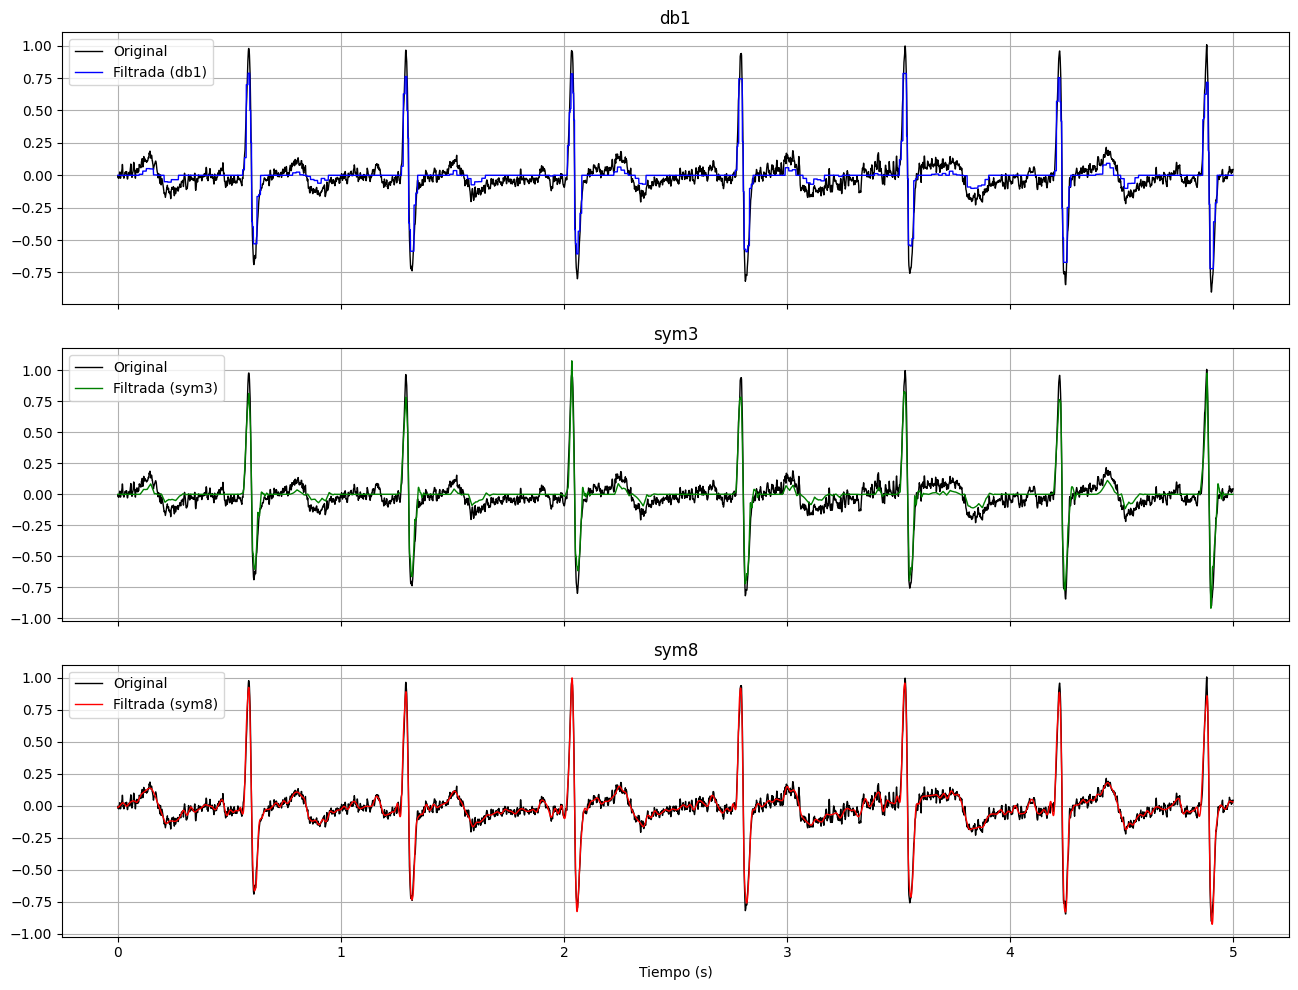

In [21]:
plt.figure(figsize=(13, 10))
time=np.array(time)
# Definir el límite de tiempo para los primeros 5 segundos
time_limit = 5  # segundos
indices = time <= time_limit

# Plotear los primeros 5 segundos
plt.figure(figsize=(13, 10))

# Primer subplot (db2)
ax1 = plt.subplot(3, 1, 1)
ax1.plot(time[indices], signal_mv[indices], lw=1, color='black', label='Original')
ax1.plot(time[indices], ecg_filtered_db1[indices], lw=1, color='blue', label='Filtrada (db1)')
ax1.set_title("db1")
ax1.grid(True)
ax1.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

# Segundo subplot (db4)
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(time[indices], signal_mv[indices], lw=1, color='black', label='Original')
ax2.plot(time[indices], ecg_filtered_sym3[indices], lw=1, color='green', label='Filtrada (sym3)')
ax2.set_title("sym3")
ax2.grid(True)
ax2.legend()
plt.setp(ax2.get_xticklabels(), visible=False)

# Tercer subplot (db6)
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(time[indices], signal_mv[indices], lw=1, color='black', label='Original')
ax3.plot(time[indices], ecg_filtered_sym8[indices], lw=1, color='red', label='Filtrada (sym8)')
ax3.set_title("sym8")
ax3.grid(True)
ax3.legend()
ax3.set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()

In [24]:
# Load of data
data1, header1 = bsnb.load("C:/Users/Equipo/OneDrive/Escritorio/Introduccion_a_señales_biomedicas/Github/inb_2024_gh12/ISB_Informes/L4_Lectura_de_ECG/ECG_L4/basal_1_normal.txt", get_header=True)
# Load of data
data2, header2 = bsnb.load("C:/Users/Equipo/OneDrive/Escritorio/Introduccion_a_señales_biomedicas/Github/inb_2024_gh12/ISB_Informes/L4_Lectura_de_ECG/ECG_L4/basal2_post_inhalation.txt", get_header=True)
# Load of data
data3, header3 = bsnb.load("C:/Users/Equipo/OneDrive/Escritorio/Introduccion_a_señales_biomedicas/Github/inb_2024_gh12/ISB_Informes/L4_Lectura_de_ECG/ECG_L4/basal3_post_ejercicio.txt", get_header=True)

channel1 = list(data1.keys())[0]
channel2 = list(data2.keys())[0]
channel3 = list(data3.keys())[0]

# Sampling rate.
sr1 = header1["sampling rate"]
# Signal Samples.
signal1 = data1[channel1]# Sampling rate.

sr2 = header2["sampling rate"]
# Signal Samples.
signal2 = data2[channel2]# Sampling rate

sr3 = header3["sampling rate"]
# Signal Samples.
signal3 = data3[channel3]

vcc = 3300 # mV
gain = 1009
signal_mv1 = (((array(signal1) / 2**resolution) - 0.5) * vcc) / gain

signal_mv2 = (((array(signal2) / 2**resolution) - 0.5) * vcc) / gain

signal_mv3 = (((array(signal3) / 2**resolution) - 0.5) * vcc) / gain

time1 = bsnb.generate_time(signal1)
time2 = bsnb.generate_time(signal2)
time3 = bsnb.generate_time(signal3)


In [25]:
# Cargar la señal ECG
ecg_signal1 = signal_mv1

# Aplicar la DWT con filtro db6 al nivel de descomposición 4
coefficients = pywt.wavedec(ecg_signal1, 'sym8', level=4)

# Estimar la desviación estándar del ruido
sigma = np.median(np.abs(coefficients[1])) / 0.6745

# Calcular el umbral universal
threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal1)))

# Realizar la umbralización suave en cada conjunto de coeficientes excepto el primero (cA)
coefficients_filtered = [coefficients[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coefficients[1:]]

# Reconstruir la señal filtrada
ecg_filtered_1= pywt.waverec(coefficients_filtered, 'sym8')

In [26]:
# Cargar la señal ECG
ecg_signal2 = signal_mv2

# Aplicar la DWT con filtro db6 al nivel de descomposición 4
coefficients = pywt.wavedec(ecg_signal2, 'sym8', level=4)

# Estimar la desviación estándar del ruido
sigma = np.median(np.abs(coefficients[1])) / 0.6745

# Calcular el umbral universal
threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal2)))

# Realizar la umbralización suave en cada conjunto de coeficientes excepto el primero (cA)
coefficients_filtered = [coefficients[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coefficients[1:]]

# Reconstruir la señal filtrada
ecg_filtered_2= pywt.waverec(coefficients_filtered, 'sym8')

In [27]:
# Cargar la señal ECG
ecg_signal3 = signal_mv3

# Aplicar la DWT con filtro db6 al nivel de descomposición 4
coefficients = pywt.wavedec(ecg_signal3, 'sym8', level=4)

# Estimar la desviación estándar del ruido
sigma = np.median(np.abs(coefficients[1])) / 0.6745

# Calcular el umbral universal
threshold = sigma * np.sqrt(2 * np.log(len(ecg_signal3)))

# Realizar la umbralización suave en cada conjunto de coeficientes excepto el primero (cA)
coefficients_filtered = [coefficients[0]] + [pywt.threshold(c, threshold, mode='soft') for c in coefficients[1:]]

# Reconstruir la señal filtrada
ecg_filtered_3= pywt.waverec(coefficients_filtered, 'sym8')

<Figure size 1300x1000 with 0 Axes>

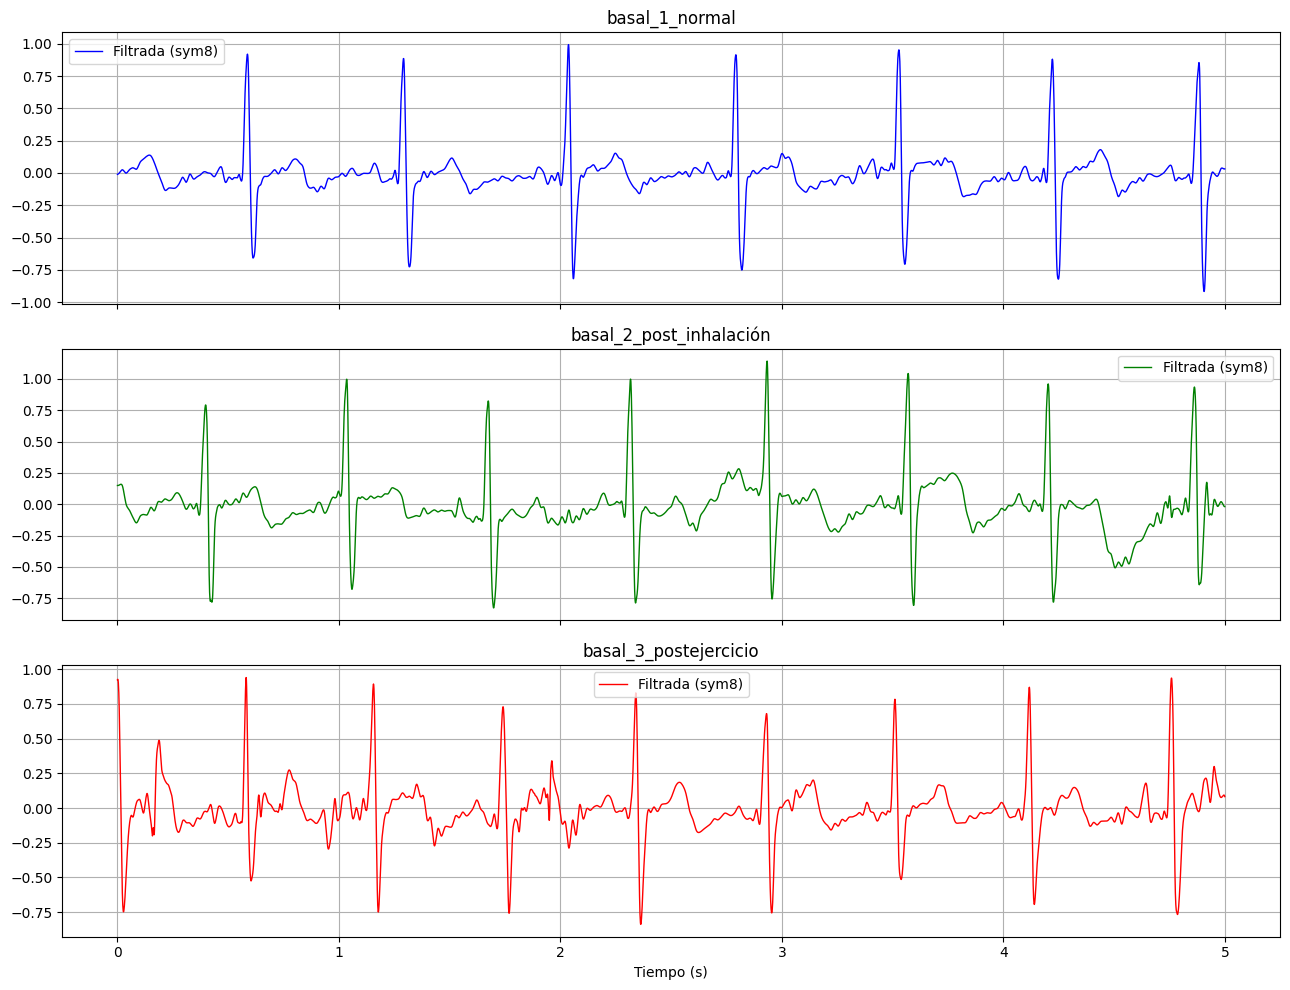

In [36]:
plt.figure(figsize=(13, 10))
time1=np.array(time1)
# Definir el límite de tiempo para los primeros 5 segundos
time_limit = 5  # segundos
indices1 = time1 <= time_limit

time2=np.array(time2)
# Definir el límite de tiempo para los primeros 5 segundos

indices2 = time2 <= time_limit

time3=np.array(time3)
# Definir el límite de tiempo para los primeros 5 segundos

indices3 = time3 <= time_limit

# Plotear los primeros 5 segundos
plt.figure(figsize=(13, 10))

# Primer subplot (db2)
ax1 = plt.subplot(3, 1, 1)
ax1.plot(time1[indices1], ecg_filtered_1[indices1], lw=1, color='blue', label='Filtrada (sym8)')
ax1.set_title("basal_1_normal")
ax1.grid(True)
ax1.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

# Segundo subplot (db4)
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(time2[indices2], ecg_filtered_2[indices2], lw=1, color='green', label='Filtrada (sym8)')
ax2.set_title("basal_2_post_inhalación")
ax2.grid(True)
ax2.legend()
plt.setp(ax2.get_xticklabels(), visible=False)

# Tercer subplot (db6)
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(time3[indices3], ecg_filtered_3[indices3], lw=1, color='red', label='Filtrada (sym8)')
ax3.set_title("basal_3_postejercicio")
ax3.grid(True)
ax3.legend()
ax3.set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()

In [28]:
# Step 2 of Pan-Tompkins Algorithm
differentiated_signal1 = diff(filtered_signal1)

differentiated_signal2 = diff(filtered_signal2)

differentiated_signal3 = diff(filtered_signal3)

In [30]:
# Step 3 of Pan-Tompkins Algorithm
squared_signal1 = differentiated_signal1 * differentiated_signal1

squared_signal2 = differentiated_signal2 * differentiated_signal2

squared_signal3 = differentiated_signal3 * differentiated_signal3

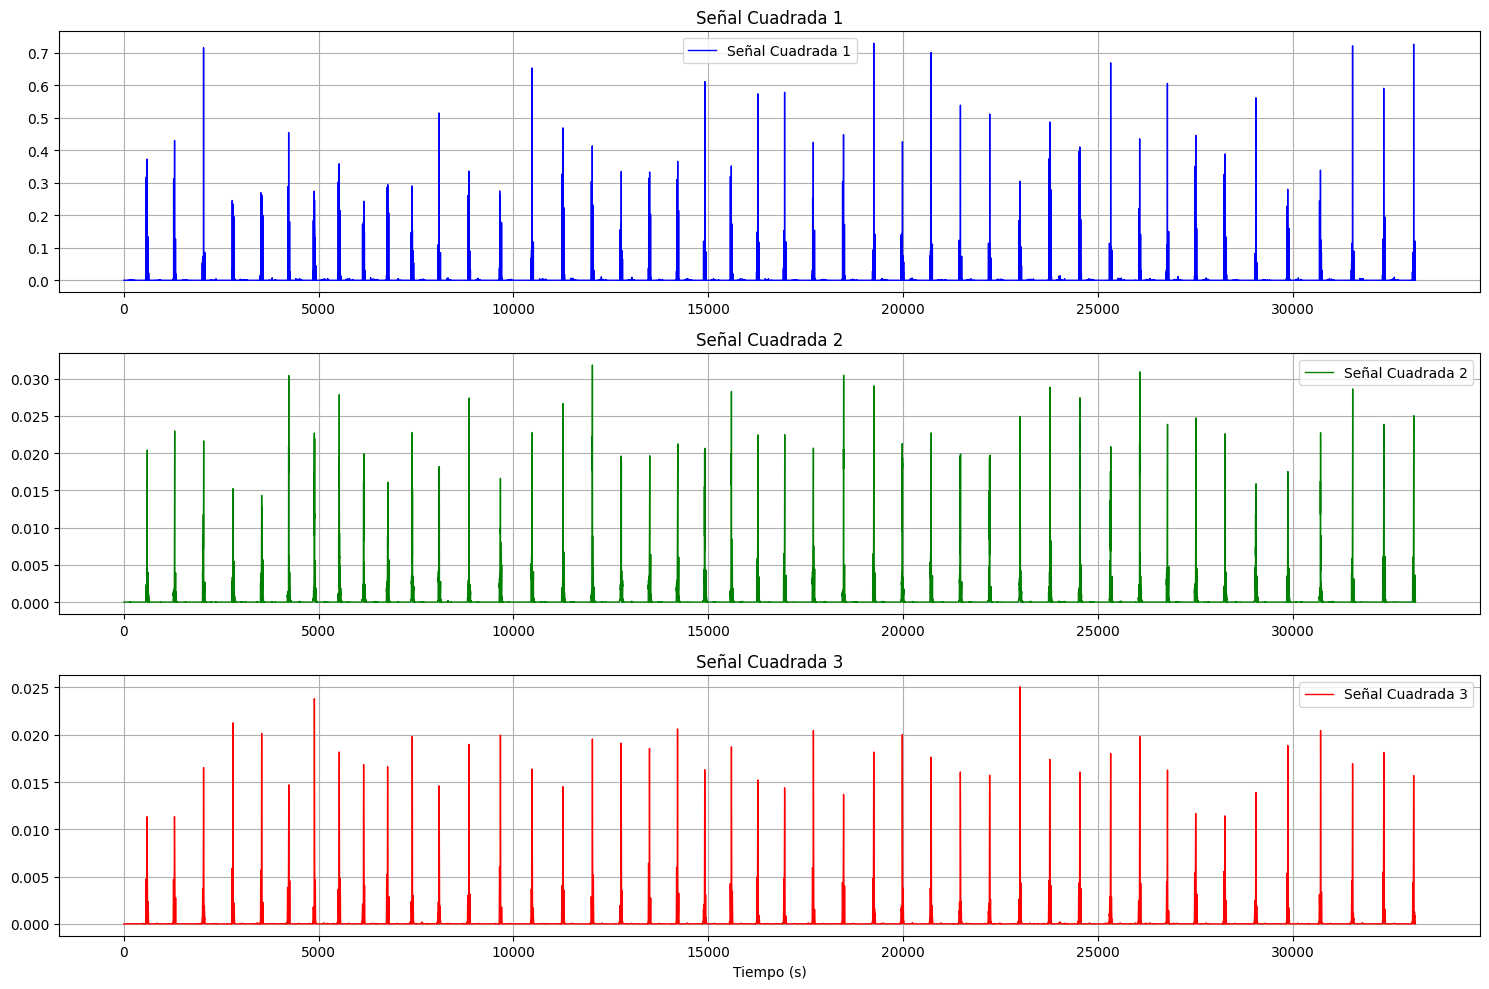

In [37]:

# Plotear las señales cuadradas
plt.figure(figsize=(15, 10))

# Primer subplot (señal cuadrada 1)
ax1 = plt.subplot(3, 1, 1)
ax1.plot(squared_signal1, lw=1, color='blue', label='Señal Cuadrada 1')
ax1.set_title("Señal Cuadrada 1")
ax1.grid(True)
ax1.legend()

# Segundo subplot (señal cuadrada 2)
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(squared_signal2, lw=1, color='green', label='Señal Cuadrada 2')
ax2.set_title("Señal Cuadrada 2")
ax2.grid(True)
ax2.legend()

# Tercer subplot (señal cuadrada 3)
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(squared_signal3, lw=1, color='red', label='Señal Cuadrada 3')
ax3.set_title("Señal Cuadrada 3")
ax3.grid(True)
ax3.legend()
ax3.set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()

In [44]:
#Definition of the samples number inside the moving average window
nbr_sampls_int_wind = int(0.080 * sr)

#Initialisation of the variable that will contain the integrated signal samples
integrated_signal1 = np.zeros_like(squared_signal1)

integrated_signal2 = np.zeros_like(squared_signal2)

integrated_signal3 = np.zeros_like(squared_signal3)

#Determination of a cumulative version of "squared_signal"
cumulative_sum1 = squared_signal1.cumsum()

cumulative_sum2 = squared_signal2.cumsum()

cumulative_sum3 = squared_signal3.cumsum()

#Estimation of the area/integral below the curve that defines the "squared_signal"
integrated_signal1[nbr_sampls_int_wind:] = (cumulative_sum1[nbr_sampls_int_wind:] - 
                                           cumulative_sum1[:-nbr_sampls_int_wind]) / nbr_sampls_int_wind
integrated_signal1[:nbr_sampls_int_wind] = cumulative_sum1[:nbr_sampls_int_wind] / np.arange(1, nbr_sampls_int_wind + 1)

integrated_signal2[nbr_sampls_int_wind:] = (cumulative_sum2[nbr_sampls_int_wind:] - 
                                           cumulative_sum2[:-nbr_sampls_int_wind]) / nbr_sampls_int_wind
integrated_signal2[:nbr_sampls_int_wind] = cumulative_sum2[:nbr_sampls_int_wind] / np.arange(1, nbr_sampls_int_wind + 1)

integrated_signal3[nbr_sampls_int_wind:] = (cumulative_sum3[nbr_sampls_int_wind:] - 
                                           cumulative_sum3[:-nbr_sampls_int_wind]) / nbr_sampls_int_wind
integrated_signal3[:nbr_sampls_int_wind] = cumulative_sum3[:nbr_sampls_int_wind] / np.arange(1, nbr_sampls_int_wind + 1)


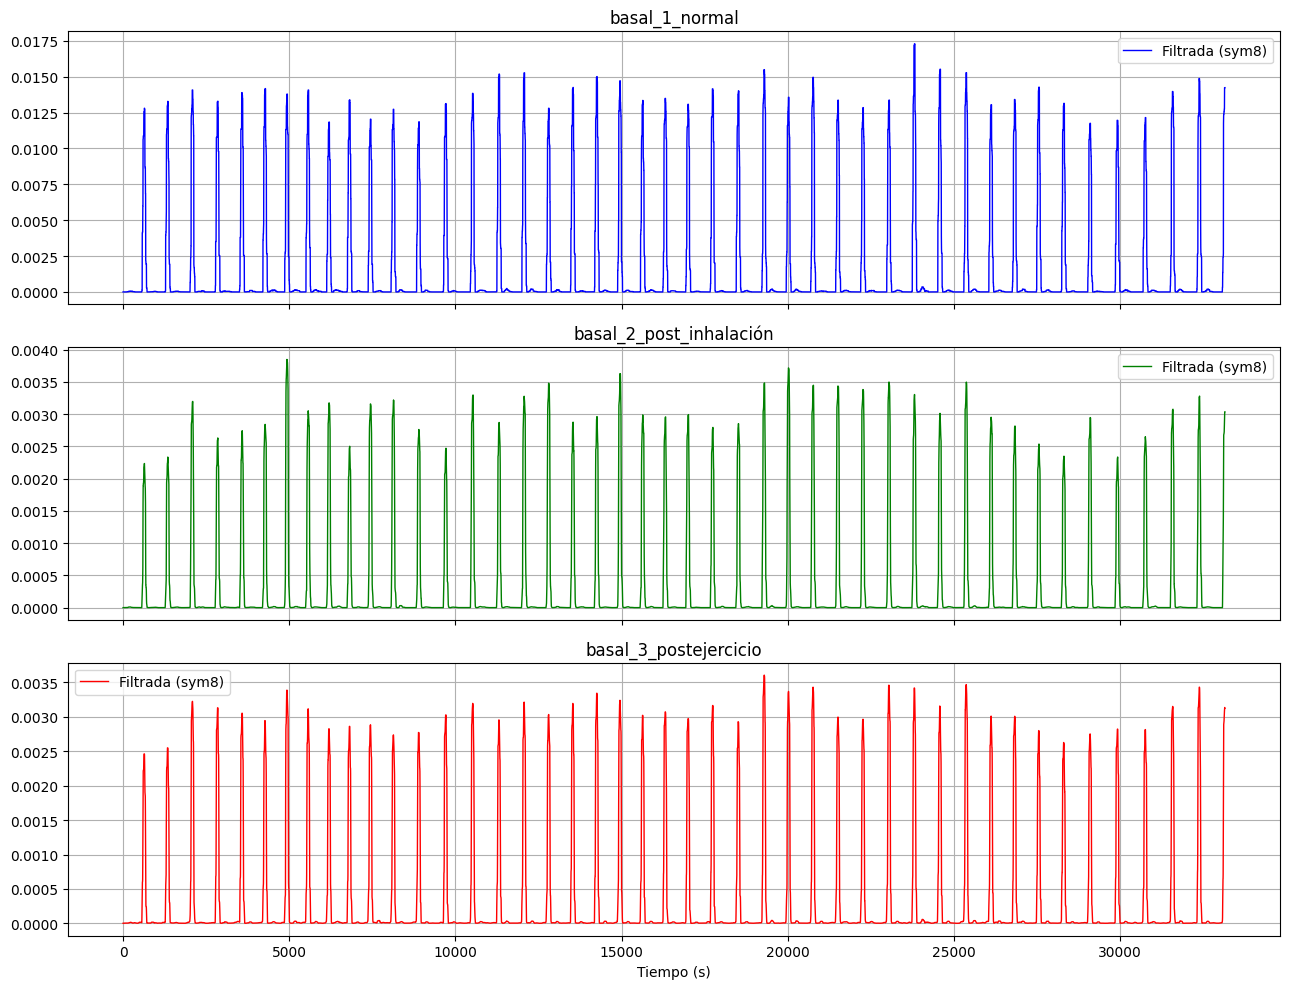

In [49]:

# Plotear 
plt.figure(figsize=(13, 10))

# Primer subplot (db2)
ax1 = plt.subplot(3, 1, 1)
ax1.plot(integrated_signal1, lw=1, color='blue', label='Filtrada (sym8)')
ax1.set_title("basal_1_normal")
ax1.grid(True)
ax1.legend()
plt.setp(ax1.get_xticklabels(), visible=False)

# Segundo subplot (db4)
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(integrated_signal2, lw=1, color='green', label='Filtrada (sym8)')
ax2.set_title("basal_2_post_inhalación")
ax2.grid(True)
ax2.legend()
plt.setp(ax2.get_xticklabels(), visible=False)

# Tercer subplot (db6)
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(integrated_signal3, lw=1, color='red', label='Filtrada (sym8)')
ax3.set_title("basal_3_postejercicio")
ax3.grid(True)
ax3.legend()
ax3.set_xlabel('Tiempo (s)')

plt.tight_layout()
plt.show()

In [66]:
# Inicialización del algoritmo de detección de picos R
#rr_buffer, signal_peak_1, noise_peak_1, threshold1 = bsnb.detect._buffer_ini(integrated_signal1, sr)
rr_buffer2, signal2_peak_1, noise2_peak_1, threshold2 = bsnb.detect._buffer_ini(integrated_signal2, sr)
rr_buffer3, signal3_peak_1, noise3_peak_1, threshold3 = bsnb.detect._buffer_ini(integrated_signal3, sr)

In [68]:
# Detección de picos probables
#probable_peaks1, possible_peaks1 = bsnb.detect._detects_peaks(integrated_signal1, sr)
probable_peaks2, possible_peaks2 = bsnb.detect._detects_peaks(integrated_signal2, sr)
probable_peaks3, possible_peaks3 = bsnb.detect._detects_peaks(integrated_signal3, sr)

In [69]:
# Verificación de picos definitivos
#definitive_peaks1 = bsnb.detect._checkup(probable_peaks1, integrated_signal1, sr, rr_buffer1, signal1_peak_1, noise1_peak_1, threshold1)
#definitive_peaks1 = np.array(list(map(int, definitive_peaks1)))

definitive_peaks2 = bsnb.detect._checkup(probable_peaks2, integrated_signal2, sr, rr_buffer2, signal2_peak_1, noise2_peak_1, threshold2)
definitive_peaks2 = np.array(list(map(int, definitive_peaks2)))

definitive_peaks3 = bsnb.detect._checkup(probable_peaks3, integrated_signal3, sr, rr_buffer3, signal3_peak_1, noise3_peak_1, threshold3)
definitive_peaks3 = np.array(list(map(int, definitive_peaks3)))

In [70]:

#map_integers1 = definitive_peaks1 - 40 * (sr / 1000)
#definitive_peaks_reph1 = array(list(map(int, map_integers1)))
map_integers2 = definitive_peaks2 - 40 * (sr / 1000)
definitive_peaks_reph2 = array(list(map(int, map_integers2)))
map_integers3 = definitive_peaks3 - 40 * (sr / 1000)
definitive_peaks_reph3 = array(list(map(int, map_integers3)))


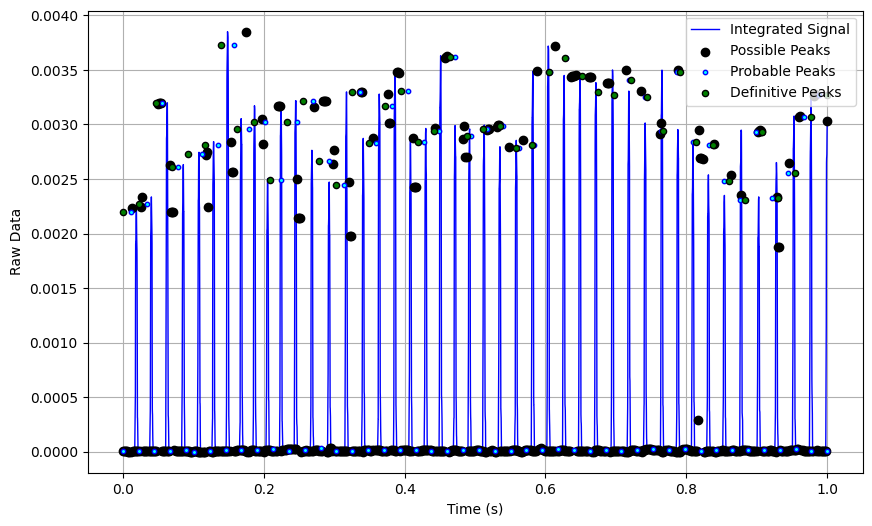

In [83]:

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, len(integrated_signal2)), integrated_signal2, lw=1, color='blue', label='Integrated Signal')

# Posible peaks
plt.scatter(np.linspace(0, 1, len(integrated_signal2[possible_peaks2])), integrated_signal2[possible_peaks2], color='black', label='Possible Peaks', zorder=3)

# Probable peaks
plt.scatter(np.linspace(0, 1,len(integrated_signal2[probable_peaks2])), integrated_signal2[probable_peaks2], color='cyan', edgecolor='blue', s=10, label='Probable Peaks', zorder=4)

# Definitive peaks
plt.scatter(np.linspace(0, 1, len(integrated_signal2[definitive_peaks2])), integrated_signal2[definitive_peaks2], color='green', edgecolor='black', s=20, label='Definitive Peaks', zorder=5)

# Configuraciones de la gráfica
plt.xlabel('Time (s)')
plt.ylabel('Raw Data')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
#mejor usamos la libreria directamente.
detected_peaks1 = bsnb.detect_r_peaks(ecg_filtered_1, sr, time_units=True, plot_result=True)

In [102]:
detected_peaks2 = bsnb.detect_r_peaks(ecg_filtered_2, sr, time_units=True, plot_result=True)

In [103]:
detected_peaks3= bsnb.detect_r_peaks(ecg_filtered_3, sr, time_units=True, plot_result=True)

In [104]:
# Verifica el tipo y contenido de detected_peaks3
print(type(detected_peaks1))
print(detected_peaks1)

<class 'tuple'>
(array([ 0.58301759,  1.28703882,  2.04706175,  2.80708468,  3.54410691,
        4.23512776,  4.89414764,  5.53316691,  6.16018583,  6.77520438,
        7.40522339,  8.07824369,  8.84226674,  9.66929168, 10.48131618,
       11.27334007, 12.02936288, 12.76638511, 13.49440707, 14.21542882,
       14.91444991, 15.59447042, 16.25749042, 16.94551118, 17.68253341,
       18.47255724, 19.25158074, 19.98360282, 20.71962503, 21.45364717,
       22.22067031, 23.00569399, 23.77071707, 24.5377402 , 25.33076413,
       26.07978672, 26.78880811, 27.51483001, 28.26185254, 29.03887598,
       29.85990075, 30.71392651, 31.53695134, 32.34297566]), array([ 0.86095864,  0.7965977 ,  0.08856983, -0.42865527, -0.44515505,
       -0.21235532, -0.31790314, -0.49803324, -0.47312821, -0.32641788,
       -0.19627992,  0.80618281,  0.82256998, -0.20359106, -0.16155633,
       -0.29350048, -0.46238356, -0.17994063, -0.13991509, -0.28323513,
       -0.49866825, -0.06294483,  0.9159269 ,  0.92930986,

In [105]:
# Suponiendo que los picos están en el primer elemento de la tupla
definitive_peaks1 = detected_peaks1[0]  # Ajusta el índice según el contenido

# Ahora continúa con el cálculo de los intervalos RR y las métricas HRV
rr_intervals = np.diff(definitive_peaks1) / sr  # Convertir a segundos

# Calcular SDNN
sdnn = np.std(rr_intervals)

# Calcular RMSSD
rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))

# Calcular pNN50
nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)
pnn50 = (nn50 / len(rr_intervals)) * 100

# Imprimir los resultados
print(f"SDNN: {sdnn:.4f} s")
print(f"RMSSD: {rmssd:.4f} s")
print(f"pNN50: {pnn50:.2f} %")


SDNN: 0.0001 s
RMSSD: 0.0000 s
pNN50: 0.00 %


In [106]:
# Suponiendo que los picos están en el primer elemento de la tupla
definitive_peaks2 = detected_peaks2[0]  # Ajusta el índice según el contenido

# Ahora continúa con el cálculo de los intervalos RR y las métricas HRV
rr_intervals = np.diff(definitive_peaks2) / sr  # Convertir a segundos

# Calcular SDNN
sdnn = np.std(rr_intervals)

# Calcular RMSSD
rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))

# Calcular pNN50
nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)
pnn50 = (nn50 / len(rr_intervals)) * 100

# Imprimir los resultados
print(f"SDNN: {sdnn:.4f} s")
print(f"RMSSD: {rmssd:.4f} s")
print(f"pNN50: {pnn50:.2f} %")


SDNN: 0.0001 s
RMSSD: 0.0000 s
pNN50: 0.00 %


In [108]:
# Suponiendo que los picos están en el primer elemento de la tupla
definitive_peaks3 = detected_peaks3[0]  # Ajusta el índice según el contenido

# Verificar los picos detectados
print(f"Definitive Peaks3: {definitive_peaks3}")

# Calcular los intervalos RR
rr_intervals = np.diff(definitive_peaks3)  # Convertir a segundos

# Verificar los intervalos RR
print(f"RR Intervals: {rr_intervals}")

# Calcular SDNN
sdnn = np.std(rr_intervals)

# Calcular RMSSD
rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))

# Calcular pNN50
nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)
pnn50 = (nn50 / len(rr_intervals)) * 100

# Imprimir los resultados
print(f"SDNN: {sdnn:.4f} s")
print(f"RMSSD: {rmssd:.4f} s")
print(f"pNN50: {pnn50:.2f} %")

Definitive Peaks3: [ 0.5960167   1.14903219  1.73704866  2.356066    2.94308244  3.50709824
  4.12911566  4.77713381  5.42315191  6.02816886  6.61918541  7.22420236
  7.8362195   8.43623631  9.02625284  9.61926945 10.23128659 10.85530407
 11.4703213  12.09733886 12.73935684 13.39137511 14.03039301 14.64841032
 15.26142749 15.87244461 16.49446203 17.10247906 17.69949578 18.28351214
 18.92052999 19.55154766 20.17956525 20.81858315 21.47160145 22.10961932
 22.72863666 23.35065408 23.98767192 24.63769013 25.26870781 25.87872489
 26.48674193 27.11475952 27.74677722 28.36579456 28.98681196 29.62282977
 30.24784728 30.86086445 31.48088182 32.12189977 32.7799182  33.4259363
 34.0469537  34.66197092 35.28198829]
RR Intervals: [0.00055302 0.00058802 0.00061902 0.00058702 0.00056402 0.00062202
 0.00064802 0.00064602 0.00060502 0.00059102 0.00060502 0.00061202
 0.00060002 0.00059002 0.00059302 0.00061202 0.00062402 0.00061502
 0.00062702 0.00064202 0.00065202 0.00063902 0.00061802 0.00061302
 0.00